In [1]:
import statistics
from collections import defaultdict
from tqdm.notebook import tqdm

import pyro
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
torch.manual_seed(7)
pyro.set_rng_seed(0)
np.random.seed(19680801)

from pyro.infer import SVI, Trace_ELBO, Importance, EmpiricalMarginal
import torch.distributions.constraints as constraints
from pyro.optim import Adam
import time
# Constants
MAX_ABUNDANCE = 100

In [2]:
print(time.asctime())

Thu Dec 17 22:30:40 2020


In [3]:
# load data
data_path = "../Tests/Data/observational_igf.csv"

data = pd.read_csv(data_path)
num_samples = data.shape[0]

single_interaction_data = data[["a(p(AKT))","a(p(Ras))","a(p(Raf))"]]
# single_interaction_data.to_csv("../bel2scm/Tests/Data/single_interaction_data.csv")

parent = single_interaction_data[["a(p(AKT))", "a(p(Ras))"]].to_numpy()
target = single_interaction_data["a(p(Raf))"].to_numpy()

In [4]:
parent.shape

(4999, 2)

In [5]:
np.ones((len(parent), 1)).shape

(4999, 1)

In [6]:

# # Log transformation
def transform_target_to_log(target):
    return np.log(target / (MAX_ABUNDANCE - target))



target_transformed_to_log = transform_target_to_log(target)


Features = np.hstack([parent, np.ones((len(parent), 1))])


In [7]:
# Linear Regression - get slope and intercept
betas = np.linalg.lstsq(Features, target_transformed_to_log, rcond=None)[0]
print(betas)

[-0.00638934  0.01390435 -0.90882721]


In [8]:
# sigmoid function
def sigmoid(x, betas):
    return MAX_ABUNDANCE / (1 + np.exp(-np.dot(x, betas)))


predicted_target = sigmoid(Features, betas)
print(predicted_target[:6])

print(target[:6])

[37.1374954  37.98374833 36.88357326 34.59710443 34.21532632 35.84862903]
[39 36 42 29 36 35]


In [9]:
# Report mean squared error

mse = np.square(np.subtract(target, predicted_target)).mean()

print("Mean squared error on train:", mse)

Mean squared error on train: 24.462852142083907


### Regression line in log space

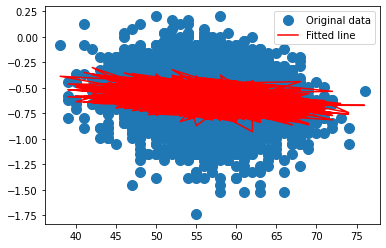

In [10]:
_ = plt.plot(parent[:,0], target_transformed_to_log, 'o', label='Original data', markersize=10)
_ = plt.plot(parent[:,0], np.dot(Features, betas), 'r', label='Fitted line')
_ = plt.legend()
plt.show()

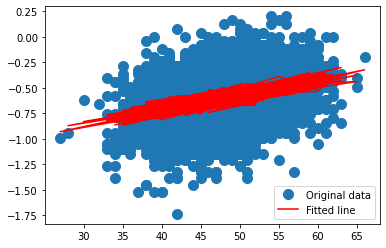

In [11]:
_ = plt.plot(parent[:,1], target_transformed_to_log, 'o', label='Original data', markersize=10)

_ = plt.plot(parent[:,1], np.dot(Features, betas), 'r', label='Fitted line')
_ = plt.legend()
plt.show()

### Regression line in actual space 

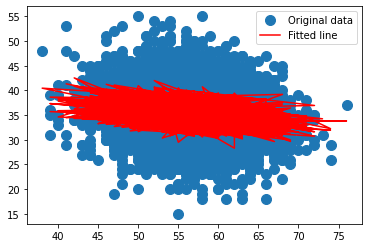

In [12]:
_ = plt.plot(parent[:,0], target, 'o', label='Original data', markersize=10)
_ = plt.plot(parent[:,0], predicted_target, 'r', label='Fitted line')
_ = plt.legend()
plt.show()

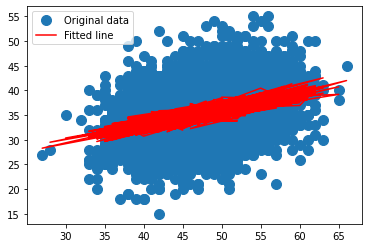

In [13]:
_ = plt.plot(parent[:,1], target, 'o', label='Original data', markersize=10)
_ = plt.plot(parent[:,1], predicted_target, 'r', label='Fitted line')
_ = plt.legend()
plt.show()

### get residual and parent statistics

In [14]:
residual_std = np.abs(np.subtract(target, predicted_target)).std()
residual_mean = np.abs(np.subtract(target, predicted_target)).mean()
print(residual_mean)
print(residual_std)

akt_mean = parent[:,0].mean()
akt_std = parent[:,0].std()

ras_mean = parent[:,1].mean()
ras_std = parent[:,1].std()

3.9397902744041375
2.9901345681748976


### Define Pyro model

In [15]:

# # sigmoid with noise
# def sigmoid_with_residual_noise(x, w, b, noise):
#     return MAX_ABUNDANCE / (1 + np.exp(-1*(w*x + b + noise)))

# pyro model
def model(n_raf):
    noise = pyro.sample("n_Raf", n_raf)
    akt = pyro.sample("AKT", pyro.distributions.Normal(akt_mean, akt_std))
    ras = pyro.sample("Ras", pyro.distributions.Normal(ras_mean, ras_std))

    parent_array = np.array([akt.detach().numpy(), ras.detach().numpy(), 1.]).reshape(-1,1).T
    raf_mean = sigmoid(parent_array, betas)+ noise.detach().numpy()
    raf = pyro.sample("Raf", pyro.distributions.Normal(torch.tensor(raf_mean), torch.tensor(1.0)))
    return akt, ras, raf

In [16]:
n_raf = pyro.distributions.Normal(torch.tensor(0.0), torch.tensor(residual_std))
samples = torch.tensor([model(n_raf) for _ in range(3000)])

In [17]:
samples[:20]

tensor([[54.6239, 35.9052, 37.0713],
        [48.9142, 49.7694, 34.6621],
        [54.0560, 44.4002, 32.6272],
        [61.8259, 41.8522, 30.2580],
        [58.0675, 42.8144, 30.3225],
        [63.6646, 52.6498, 37.6942],
        [62.6690, 40.6750, 32.0026],
        [52.4279, 50.3884, 35.3697],
        [58.9440, 35.6905, 32.0674],
        [53.5527, 49.0715, 32.1569],
        [57.6283, 47.5633, 34.0407],
        [54.7625, 48.6208, 32.3575],
        [55.9568, 47.9405, 40.8257],
        [70.3811, 48.5449, 35.9028],
        [52.7250, 54.7083, 33.6422],
        [55.4504, 57.7673, 40.9600],
        [54.4040, 39.1741, 32.7822],
        [62.1902, 49.9314, 37.5981],
        [60.7229, 51.7271, 32.0112],
        [58.9915, 44.4960, 34.6030]], dtype=torch.float64)

### Generated samples Vs. Original Data

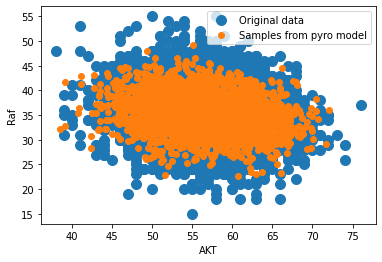

In [18]:
_ = plt.plot(parent[:,0], target, 'o', label='Original data', markersize=10)
_ = plt.plot(samples[:,0], samples[:,2], 'o', label='Samples from pyro model')
_ = plt.legend()
_= plt.xlabel("AKT")
_= plt.ylabel("Raf")
plt.show()

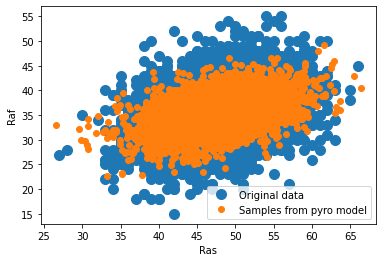

In [19]:
_ = plt.plot(parent[:,1], target, 'o', label='Original data', markersize=10)
_ = plt.plot(samples[:,1], samples[:,2], 'o', label='Samples from pyro model')
_ = plt.legend()
_ = plt.xlabel("Ras")
_ = plt.ylabel("Raf")
plt.show()

## Counterfactual Inference

In [20]:

def infer_using_svi(conditioned_model, n_raf):

    def guide(n_raf):
        mu_constraints = constraints.interval(0., 5.)
        sigma_constraints = constraints.interval(.1, 7.)
        mu_guide = pyro.param("mu_n_Raf", torch.tensor(0.0), constraint=mu_constraints)
        sigma_guide = pyro.param("sigma_n_Raf", torch.tensor(residual_std),
                                     constraint=sigma_constraints)
        pyro.sample("n_Raf", pyro.distributions.Normal(mu_guide, sigma_guide))

    pyro.clear_param_store()

    svi = SVI(
        model=conditioned_model,
        guide=guide,
        optim=Adam({"lr": 0.05, "betas": (0.95, 0.999)}),
        loss=Trace_ELBO(retain_graph=True)
    )
    losses = []
    num_steps = 1000
    samples = defaultdict(list)
    for t in tqdm(range(num_steps)):
        loss = svi.step(n_raf)
        #print(t, loss)
        losses.append(loss)
        mu = 'mu_n_Raf'
        sigma = 'sigma_n_Raf'
        samples[mu].append(pyro.param(mu).item())
        samples[sigma].append(pyro.param(sigma).item())
    means = {k: statistics.mean(v) for k, v in samples.items()}

    updated_noise = {}
    updated_noise = pyro.distributions.Normal(means["mu_n_Raf"], means["sigma_n_Raf"])

    return updated_noise, losses

In [21]:
def counterfactual_inference(parent_name, intervened_parent):
    n_raf = pyro.distributions.Normal(0.0, torch.tensor(residual_std))

    # Generate a sample
    observed_akt, observed_ras, observed_raf = model(n_raf)

    print("Observed AKT:", observed_akt,"Observed Ras:", observed_ras, "Observed Raf:", observed_raf)
    print("What would happen to Raf if {} was {} ?".format(parent_name, intervened_parent))
    conditioned_model = pyro.condition(model, data={"AKT": observed_akt, "Ras": observed_ras, 
                                                    "Raf": observed_raf})
    
    updated_n_raf= infer_using_svi(conditioned_model, n_raf)
    #update noise for everything
    intervention_model = pyro.do(model, data={parent_name:torch.tensor(intervened_parent)})
    return intervention_model, updated_n_raf[0]

In [22]:
def counterfactual_inference_ras(intervened_ras):
    n_raf = pyro.distributions.Normal(0.0, torch.tensor(residual_std))

    # Generate a sample
    observed_akt, observed_ras, observed_raf = model(n_raf)

    print("Observed AKT:", observed_akt,"Observed Ras:", observed_ras, "Observed Raf:", observed_raf)
    print("What would happen to Raf if Ras was", intervened_ras, "?")
    conditioned_model = pyro.condition(model, data={"AKT": observed_akt,"Ras": observed_ras, "Raf": observed_raf})
    updated_n_raf = infer_using_svi(conditioned_model, n_raf)

    intervention_model = pyro.do(model, data={"Ras":torch.tensor(intervened_ras)})
    return intervention_model, updated_n_raf[0]

In [23]:
intervened_model_1, noise_1 = counterfactual_inference("AKT", 40.)
intervened_model_2, noise_2 = counterfactual_inference("AKT", 70.)
intervened_model_3, noise_3 = counterfactual_inference_ras(40.)
intervened_model_4, noise_4 = counterfactual_inference_ras(70.)

counterfactual_raf_1 = torch.tensor([intervened_model_1(noise_1)[2] for _ in range(1000)])
counterfactual_raf_2 = torch.tensor([intervened_model_2(noise_2)[2] for _ in range(1000)])


counterfactual_raf_3 = torch.tensor([intervened_model_3(noise_3)[2] for _ in range(1000)])
counterfactual_raf_4 = torch.tensor([intervened_model_4(noise_4)[2] for _ in range(1000)])

Observed AKT: tensor(56.9580) Observed Ras: tensor(50.6495) Observed Raf: tensor([30.1093], dtype=torch.float64)
What would happen to Raf if AKT was 40.0 ?



Observed AKT: tensor(63.8523) Observed Ras: tensor(34.6226) Observed Raf: tensor([28.3015], dtype=torch.float64)
What would happen to Raf if AKT was 70.0 ?



Observed AKT: tensor(53.3404) Observed Ras: tensor(45.2378) Observed Raf: tensor([30.8170], dtype=torch.float64)
What would happen to Raf if Ras was 40.0 ?



Observed AKT: tensor(55.4920) Observed Ras: tensor(43.6304) Observed Raf: tensor([33.8547], dtype=torch.float64)
What would happen to Raf if Ras was 70.0 ?


In [24]:
noise_1, noise_2

(Normal(loc: 5.877471754111438e-38, scale: 3.0063846111297607),
 Normal(loc: 5.877471754111438e-38, scale: 2.889981508255005))

In [25]:
noise_3, noise_4

(Normal(loc: 5.877471754111438e-38, scale: 2.961458921432495),
 Normal(loc: 5.877471754111438e-38, scale: 2.9940004348754883))

In [26]:
print(counterfactual_raf_1[:10])
print(counterfactual_raf_2[:10])
print(counterfactual_raf_3[:10])
print(counterfactual_raf_4[:10])

tensor([34.1106, 38.6796, 33.6547, 35.5002, 41.9012, 40.3738, 34.7778, 35.1026,
        35.5344, 34.3244], dtype=torch.float64)
tensor([36.0519, 35.0887, 33.9694, 38.8792, 30.7567, 31.9899, 34.8484, 39.1008,
        30.0918, 30.4787], dtype=torch.float64)
tensor([36.3325, 35.1403, 30.0225, 33.1640, 30.9280, 36.4128, 37.7326, 40.1104,
        31.2993, 37.2360], dtype=torch.float64)
tensor([48.3722, 41.3856, 45.3652, 45.6163, 43.6086, 46.6485, 45.8878, 38.3553,
        41.5763, 43.0048], dtype=torch.float64)


In [27]:
print("Counterfactual Raf when AKT = 40:: Mean", counterfactual_raf_1.mean(), counterfactual_raf_1.std())
print("Counterfactual Raf when AKT = 70:: Mean", counterfactual_raf_2.mean(), counterfactual_raf_2.std())
print("Counterfactual Raf when Ras = 40:: Mean", counterfactual_raf_3.mean(), counterfactual_raf_3.std())
print("Counterfactual Raf when Ras = 70:: Mean", counterfactual_raf_4.mean(), counterfactual_raf_4.std())

Counterfactual Raf when AKT = 40:: Mean tensor(37.8302, dtype=torch.float64) tensor(3.4946, dtype=torch.float64)
Counterfactual Raf when AKT = 70:: Mean tensor(33.3243, dtype=torch.float64) tensor(3.3390, dtype=torch.float64)
Counterfactual Raf when Ras = 40:: Mean tensor(32.8862, dtype=torch.float64) tensor(3.1973, dtype=torch.float64)
Counterfactual Raf when Ras = 70:: Mean tensor(42.7534, dtype=torch.float64) tensor(3.1419, dtype=torch.float64)
